In [1]:
from fredapi import Fred
import pandas as pd
import matplotlib.pyplot as plt
from tslite.splitters import RollingSplitter
from tslite.backtest import backtest

fred = Fred(api_key="1bd230d4c6a9155609eb4b91f4ddc453")


/Users/luisangelalcantara/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/luisangelalcantara/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [ ]:

search = fred.search('Insurance Companies and Pension Funds',
                      order_by='popularity', sort_order='desc')


display(search[['title', 'id']].head())


serie_id ='BOGZ1FA583150005Q' #'BOGZ1FL544090005Q' 
data = fred.get_series(serie_id)

,title,id
series id,,
BOGZ1FA583065005Q,Insurance Companies and Pension Funds; Total M...,BOGZ1FA583065005Q
BOGZ1FU543050085Q,"Life Insurance Companies, Separate Accounts; P...",BOGZ1FU543050085Q
BOGZ1FA874190015Q,"Other Financial Corporations, Money Market Fun...",BOGZ1FA874190015Q
BOGZ1FA803192005A,Other Financial Intermediaries Except Insuranc...,BOGZ1FA803192005A
BOGZ1FL873081015A,"Other Financial Corporations, Money Market Fun...",BOGZ1FL873081015A


In [26]:
# y base
y = data.loc['2000-01-01':].dropna()




In [ ]:
splitter = RollingSplitter(window=84, horizon=7, step=7, expanding=True)
res_holt = backtest(y=y, model_name="holt",
                    model_params={"exponential": False, "damped_trend": True},
                    splitter=splitter)


/Users/luisangelalcantara/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/luisangelalcantara/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [33]:
folds = []
for tr_idx, vl_idx in splitter.split(len(y)):
    tr_idx = list(tr_idx); vl_idx = list(vl_idx)
    folds.append({
        "train_start": y.index[tr_idx[0]],
        "train_end":   y.index[tr_idx[-1]],
        "val_start":   y.index[vl_idx[0]],
        "val_end":     y.index[vl_idx[-1]],
        "train_len":   len(tr_idx),
        "val_len":     len(vl_idx),
    })

folds_df = pd.DataFrame(folds)
display(folds_df)


,train_start,train_end,val_start,val_end,train_len,val_len
0,2000-01-01,2020-10-01,2021-01-01,2022-07-01,84,7
1,2000-01-01,2022-07-01,2022-10-01,2024-04-01,91,7


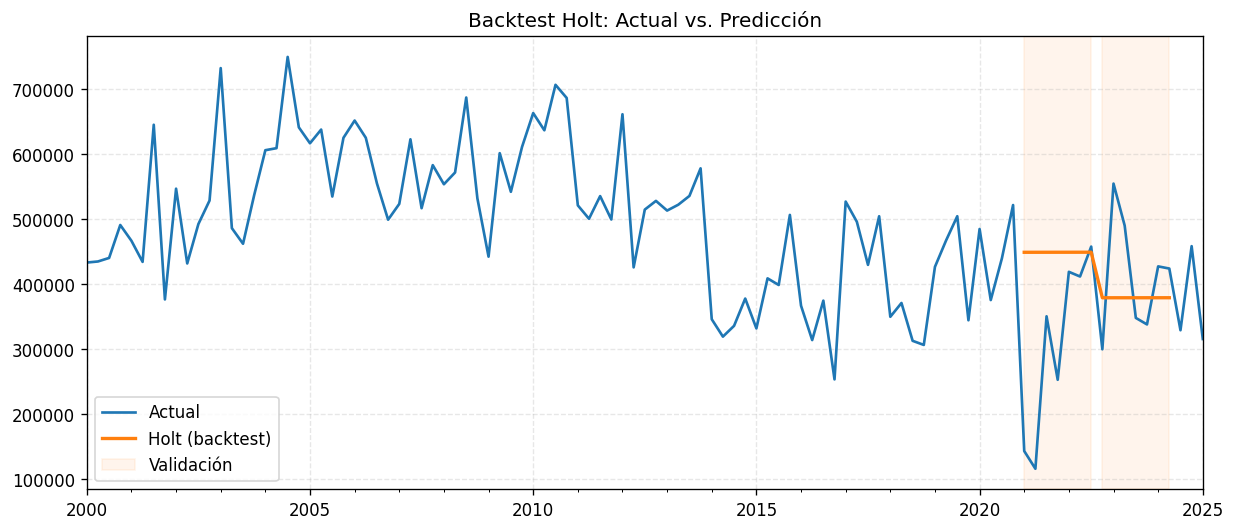

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=120)
y.plot(ax=ax, label="Actual", lw=1.6)
res_holt.predictions.plot(ax=ax, label="Holt (backtest)", lw=2)

labeled = False
for tr_idx, vl_idx in splitter.split(len(y)):
    x0 = y.index[vl_idx[0]]
    x1 = y.index[vl_idx[-1]]
    ax.axvspan(x0, x1, alpha=0.08, color="tab:orange",
               label="Validación" if not labeled else None)
    labeled = True

ax.set_title("Backtest Holt: Actual vs. Predicción")
ax.set_xlabel("")
ax.grid(True, linestyle="--", alpha=0.3)
ax.legend()
plt.show()

In [ ]:
print(res_holt.metrics_by_fold)          
print("\nResumen:")
print(res_holt.metrics_by_fold.describe())  


             mae           rmse      mape
0  144038.568828  190595.018995  0.888834
1   75777.233265   89684.067710  0.176484

Resumen:
                 mae           rmse      mape
count       2.000000       2.000000  2.000000
mean   109907.901047  140139.543353  0.532659
std     48268.053270   71354.817950  0.503707
min     75777.233265   89684.067710  0.176484
25%     92842.567156  114911.805532  0.354572
50%    109907.901047  140139.543353  0.532659
75%    126973.234937  165367.281174  0.710747
max    144038.568828  190595.018995  0.888834
